In [17]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from itertools import product
from functools import partial
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib as mpl

# Simulation

In [2]:
def transition_function(state, p):
    """
    Transition function for the infinte 1st quadrant Markov chain.
    """
    i, j = state
    if i == 1 and j == 1:
        return {
            (1,1): 1-p,
            (2,1): p/2,
            (1,2): p/2
        }
    elif i ==1  and j > 1:
        return {
            (i,j): (1-p)/2,
            (i+1,j): p/2,
            (i,j+1): p/2,
            (i,j-1): (1-p)/2
        }
    elif i > 1 and j == 1:
        return {
            (i,j): (1-p)/2,
            (i+1,j): p/2,
            (i-1,j): (1-p)/2,
            (i,j+1): p/2
        }
    else:
        return {
            (i+1,j): p/2,
            (i-1,j): (1-p)/2,
            (i,j+1): p/2,
            (i,j-1): (1-p)/2
        }

In [3]:
def simulate_markov_chain(transition_func, initial_state, steps,
                          return_trajectory=True,
                          return_state_count=True):
    """
    Simulate a Markov chain given a transition function and an initial state.
    """
    state = initial_state
    res = {
        'state': initial_state,
        'trajectory': [initial_state] if return_trajectory else None,
        'state_count': defaultdict(lambda: 0) if return_state_count else None
    }
    if return_state_count:
        res['state_count'][initial_state] += 1
    
    for _ in range(steps):
        transitions = transition_func(res['state'])
        state_idx = np.random.choice(
            range(len(transitions)),
            p=list(transitions.values()))
        res['state'] = list(transitions.keys())[state_idx]
        if return_trajectory:
            res['trajectory'].append(state)
        if return_state_count:
            res['state_count'][res['state']] += 1
    
    if return_trajectory:
        res['trajectory'] = np.array(res['trajectory'])
    return res

In [4]:
def manhattan_distance(state1, state2):
    """
    Calculate the Manhattan distance between two states.
    """
    return np.abs(state1 - state2).sum()

# Stationary distribution

In [37]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [5]:
stationary_data = {
    'n_steps': [],
    'p': [],
    'state_i': [],
    'state_j': [],
    'count': [],
}
initial_state = (1, 1)
probabilities = np.array([.25, .35, .45])
steps = 10**np.arange(1, 4)
iterator = product(
    probabilities,
    steps
)
for p, n_steps in tqdm(iterator, total=len(probabilities) * len(steps)):
    # Simulate the Markov chain
    res = simulate_markov_chain(
        partial(transition_function, p=p),
        initial_state=initial_state,
        steps=n_steps,
        return_trajectory=False,
        return_state_count=True
    )
    for state, count in res['state_count'].items():
        stationary_data['n_steps'].append(n_steps)
        stationary_data['p'].append(p)
        stationary_data['state_i'].append(state[0])
        stationary_data['state_j'].append(state[1])
        stationary_data['count'].append(count)
stationary_data = pd.DataFrame.from_dict(stationary_data)
stationary_data

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 73.00it/s]


,n_steps,p,state_i,state_j,count
0,10,0.25,1,1,7
1,10,0.25,1,2,3
2,10,0.25,1,3,1
3,100,0.25,1,1,61
4,100,0.25,2,1,22
...,...,...,...,...,...
316,1000,0.45,6,6,1
317,1000,0.45,7,7,1
318,1000,0.45,4,6,3
319,1000,0.45,1,8,2


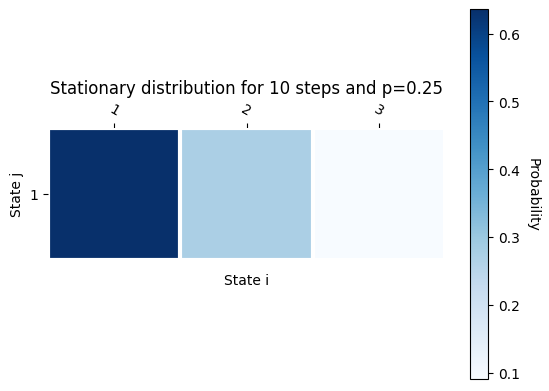

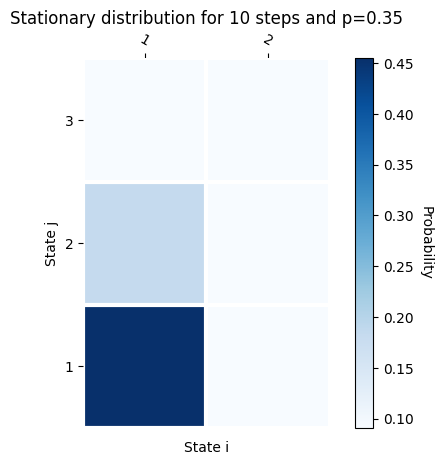

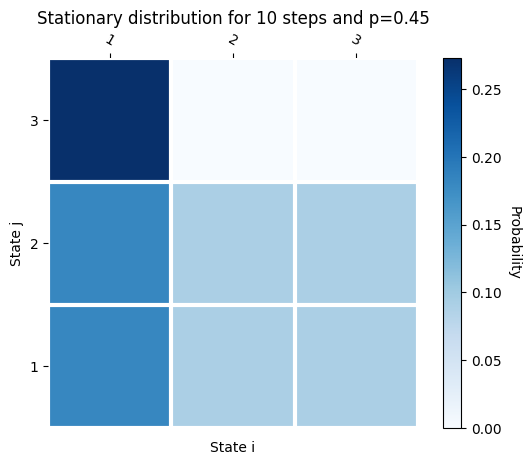

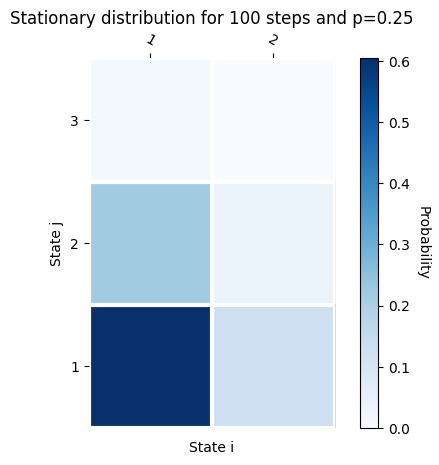

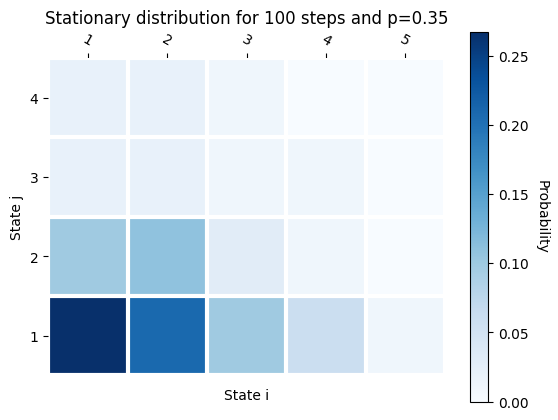

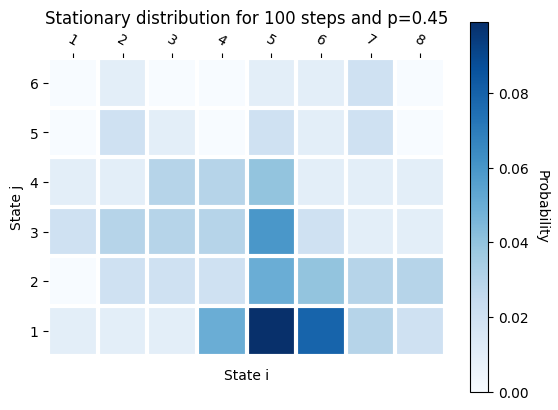

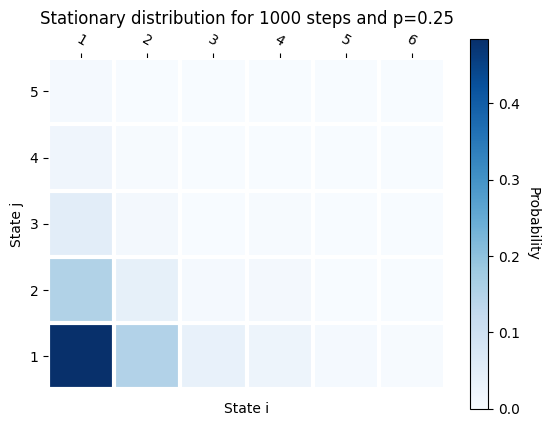

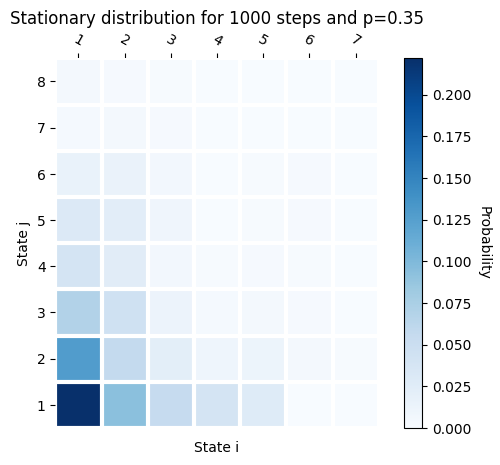

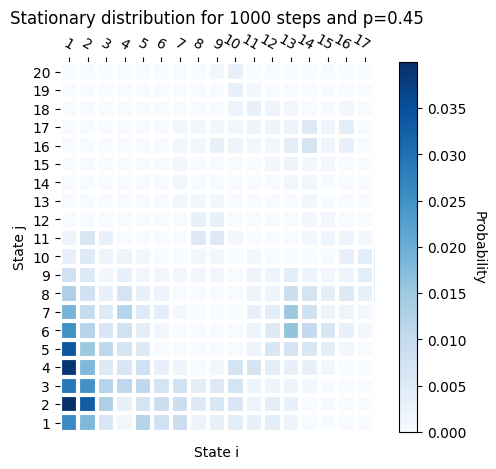

In [38]:
for (n_steps, p), data in stationary_data.groupby(['n_steps', 'p']):
    fig, ax = plt.subplots()
    ax.set(
        title=f"Stationary distribution for {n_steps} steps and p={p}",
        xlabel="State i",
        ylabel="State j",
    )
    max_i = data['state_i'].max()
    max_j = data['state_j'].max()
    distribution = np.zeros((max_i, max_j))
    n_states = data['count'].sum()
    for i, j, count in zip(data['state_i'], data['state_j'], data['count']):
        distribution[i-1, j-1] = count/n_states
    # Flips the distribution to have the origin at the bottom left
    # corner
    distribution = distribution[::-1]
    xticks = np.arange(max_i, 0, -1)
    yticks = np.arange(1, max_j+1)
    im, cbar = heatmap(distribution, xticks, yticks, ax=ax,
                   cmap="Blues", cbarlabel="Probability")
    # hist, x_bins, y_bins, color_mesh = ax.hist2d(
    #     data['state_i'],
    #     data['state_j'],
    #     bins=(np.arange(1, data['state_i'].max()+1),
    #           np.arange(1, data['state_j'].max()+1)),
    #     weights=data['count'],
    #     cmap='Blues',
    #     density=True,
    # )
    # fig.colorbar(color_mesh, ax=ax)

# Manhattan distance

In [13]:
probabilities = np.array([.25, .35, .45])
# steps = np.array([10, 100, 1000])
steps = np.logspace(1, 4, num=10, dtype=int)
df = pd.DataFrame(
    columns=['p', 'steps'],
    data=np.array(list(product(probabilities, steps)))
)
df['n'] = 1e3
df['last_states'] = None
df.head()

,p,steps,n,last_states
0,0.25,10.0,1000.0,None
1,0.25,21.0,1000.0,None
2,0.25,46.0,1000.0,None
3,0.25,100.0,1000.0,None
4,0.25,215.0,1000.0,None


In [14]:
initial_state = np.array([1, 1])
for i, row in df.iterrows():
    print(f"Simulating for p={row['p']}, steps={row['steps']} and n={row['n']}")
    aux_transition_function = partial(transition_function, p=row['p'])
    last_states = []
    for _ in range(int(row['n'])):
        res = simulate_markov_chain(aux_transition_function,
                                  initial_state,
                                  int(row['steps']),
                                  return_trajectory=False,
                                  return_state_count=False)
        last_states.append(res['state'])
    df.at[i, 'last_states'] = np.array(last_states)
df['manhattan_distances'] = df['last_states'].apply(
    lambda x: np.array([
        manhattan_distance(last_state, initial_state)
        for last_state in x
    ])
)
df['mean_manhattan_distance'] = df['manhattan_distances'].apply(
    lambda x: np.mean(x)
)
df['std_manhattan_distance'] = df['manhattan_distances'].apply(
    lambda x: np.std(x)
)
df

Simulating for p=0.25, steps=10.0 and n=1000.0
Simulating for p=0.25, steps=21.0 and n=1000.0
Simulating for p=0.25, steps=46.0 and n=1000.0
Simulating for p=0.25, steps=100.0 and n=1000.0
Simulating for p=0.25, steps=215.0 and n=1000.0
Simulating for p=0.25, steps=464.0 and n=1000.0
Simulating for p=0.25, steps=1000.0 and n=1000.0
Simulating for p=0.25, steps=2154.0 and n=1000.0
Simulating for p=0.25, steps=4641.0 and n=1000.0
Simulating for p=0.25, steps=10000.0 and n=1000.0
Simulating for p=0.35, steps=10.0 and n=1000.0
Simulating for p=0.35, steps=21.0 and n=1000.0
Simulating for p=0.35, steps=46.0 and n=1000.0
Simulating for p=0.35, steps=100.0 and n=1000.0
Simulating for p=0.35, steps=215.0 and n=1000.0
Simulating for p=0.35, steps=464.0 and n=1000.0
Simulating for p=0.35, steps=1000.0 and n=1000.0
Simulating for p=0.35, steps=2154.0 and n=1000.0
Simulating for p=0.35, steps=4641.0 and n=1000.0
Simulating for p=0.35, steps=10000.0 and n=1000.0
Simulating for p=0.45, steps=10.0 an

,p,steps,n,last_states,manhattan_distances,mean_manhattan_distance,std_manhattan_distance
0,0.25,10.0,1000.0,"[[1, 1], [1, 4], [2, 2], [1, 1], [1, 3], [1, 1...","[0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, ...",0.836,1.071029
1,0.25,21.0,1000.0,"[[1, 2], [1, 1], [2, 1], [1, 1], [1, 1], [2, 2...","[1, 0, 1, 0, 0, 2, 1, 0, 3, 0, 0, 0, 3, 0, 2, ...",0.923,1.123864
2,0.25,46.0,1000.0,"[[1, 1], [1, 3], [1, 2], [3, 1], [1, 1], [1, 2...","[0, 2, 1, 2, 0, 1, 0, 3, 0, 2, 1, 1, 0, 0, 0, ...",0.903,1.154812
3,0.25,100.0,1000.0,"[[1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1...","[0, 0, 2, 0, 2, 0, 0, 2, 3, 0, 0, 1, 2, 2, 3, ...",0.916,1.170873
4,0.25,215.0,1000.0,"[[1, 1], [1, 5], [1, 2], [1, 3], [1, 1], [1, 3...","[0, 4, 1, 2, 0, 2, 0, 0, 1, 0, 2, 3, 0, 1, 2, ...",1.025,1.281552
5,0.25,464.0,1000.0,"[[1, 1], [1, 1], [1, 3], [1, 1], [5, 1], [2, 1...","[0, 0, 2, 0, 4, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, ...",1.030,1.210413
6,0.25,1000.0,1000.0,"[[1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1...","[0, 0, 0, 0, 1, 0, 0, 1, 3, 1, 0, 0, 1, 0, 1, ...",1.043,1.323311
7,0.25,2154.0,1000.0,"[[1, 1], [1, 2], [2, 1], [1, 1], [1, 1], [1, 1...","[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, ...",1.002,1.214082
8,0.25,4641.0,1000.0,"[[1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [2, 1...","[1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, ...",1.053,1.268933
9,0.25,10000.0,1000.0,"[[1, 1], [1, 1], [1, 2], [2, 1], [1, 1], [2, 1...","[0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, ...",0.921,1.177607


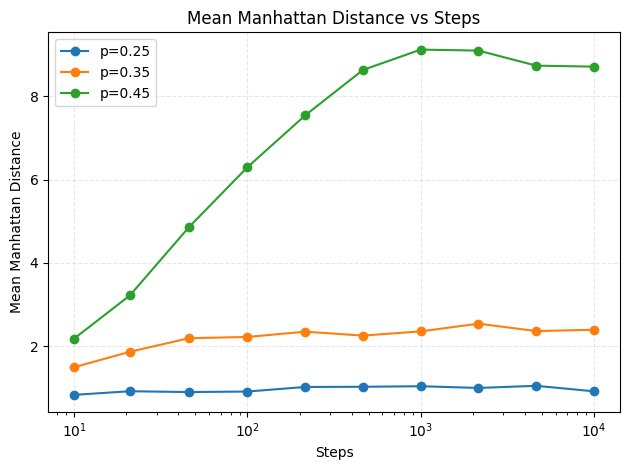

In [16]:
fig, ax = plt.subplots()
ax.grid(linestyle='--', alpha=.3)
ax.set(
    xlabel='Steps',
    ylabel='Mean Manhattan Distance',
    title='Mean Manhattan Distance vs Steps',
    xscale='log',
)
for p, data in df.groupby('p'):
    data.sort_values('steps', inplace=True)
    ax.plot(
        data['steps'],
        data['mean_manhattan_distance'],
        marker='o',
        label=f"p={p}"
    )
ax.legend()
fig.tight_layout()